In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import xmeos
from xmeos import models

%matplotlib notebook

In [2]:
dat = pd.read_csv('data/MgSiO3-electron-entropy-deKoker2009.csv')
dat_6K = dat.loc[dat['T']==6000]
dat_4K = dat.loc[dat['T']==4000]



In [3]:
kboltz=xmeos.models.CONSTS['kboltz']
PV_ratio = xmeos.models.CONSTS['PV_ratio']
def _calc_pow_law(Vfrac, const0=None, exp_coef=None, V0=None, deriv=0):
    val = const0*Vfrac**exp_coef
    if deriv==0:
        pass
    elif deriv==1:
        V = Vfrac*V0
        val *= exp_coef/V
    else:
        assert False, 'deriv is not a valid derivative order.'
    
    return val



def eval_S_elec(Vfrac, T, param):
    Tel0 = param[0]
    Tel_exp = param[1]
    zeta0 = param[2]
    zeta_exp = param[3]
    
    zeta = _calc_pow_law(Vfrac, const0=zeta0, exp_coef=zeta_exp)
    Tel = _calc_pow_law(Vfrac, const0=Tel0, exp_coef=Tel_exp)
    
    Sel = zeta*(T-Tel-Tel*np.log(T/Tel))
    Sel[T<=Tel] = 0
    return Sel

def eval_E_elec(Vfrac, T, param):
    Tel0 = param[0]
    Tel_exp = param[1]
    zeta0 = param[2]
    zeta_exp = param[3]

    zeta = _calc_pow_law(Vfrac, const0=zeta0, exp_coef=zeta_exp)
    Tel = _calc_pow_law(Vfrac, const0=Tel0, exp_coef=Tel_exp)
    
    Eel = kboltz*0.5*zeta*(T-Tel)**2
    Eel[T<=Tel] = 0
    return Eel

def eval_P_elec(Vfrac, T, param, V0=1):
    Tel0 = param[0]
    Tel_exp = param[1]
    zeta0 = param[2]
    zeta_exp = param[3]
    
    zeta = _calc_pow_law(Vfrac, const0=zeta0, exp_coef=zeta_exp)
    zeta_deriv = _calc_pow_law(Vfrac, const0=zeta0, exp_coef=zeta_exp, V0=V0, deriv=1)
    
    Tel = _calc_pow_law(Vfrac, const0=Tel0, exp_coef=Tel_exp)
    Tel_deriv = _calc_pow_law(Vfrac, const0=Tel0, exp_coef=Tel_exp, V0=V0, deriv=1)
    
    Pel = kboltz*PV_ratio*(zeta_deriv*(0.5*(T**2-Tel**2) - T*Tel*np.log(T/Tel)) + 
                           zeta*Tel_deriv*(T-Tel-T*np.log(T/Tel)))
           
    Pel[T<=Tel] = 0
    return Pel

In [4]:
eos_mod = models.ElectronicEos(kind='CvPowLaw')
eos_mod.entropy(50,8000)/xmeos.models.CONSTS['kboltz']

eos_mod.set_param_values(param_names=['V0', 'Tel0', 'TelExp', 'CvelFac0', 'CvelFacExp' ],
                        param_values=[12.97, 3000, -.3, 2.7e-4,+.6])
param0 = eos_mod.get_param_values(param_names=['Tel0', 'TelExp', 'CvelFac0', 'CvelFacExp'])
V0, = eos_mod.get_param_values(param_names=['V0']) 

Vfrac = np.linspace(.35,1.25,1001)
Vmod = V0*Vfrac
print(param0)
print(V0)

[  3.00000000e+03  -3.00000000e-01   2.70000000e-04   6.00000000e-01]
12.97


<IPython.core.display.Javascript object>


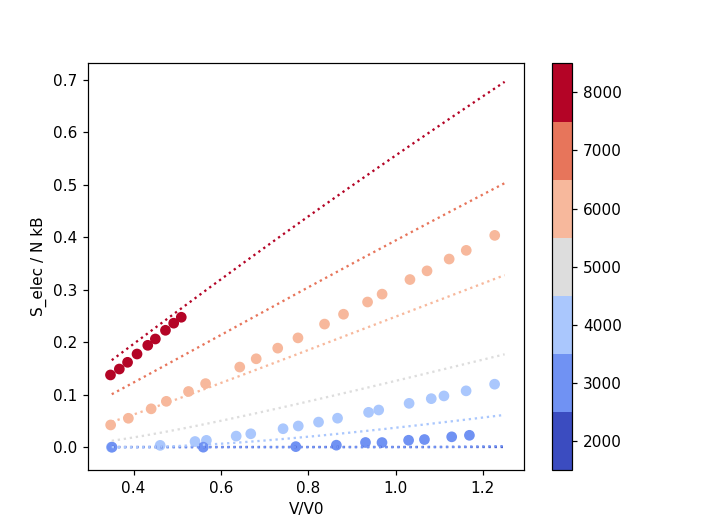

In [5]:
# Initial fit by hand

plt.figure()


T0_ref = 4000

cmap = plt.get_cmap('coolwarm',7)
plt.scatter(dat['Vratio'],dat['S'],c=dat['T'],cmap=cmap)


Tmod = [2000,3000,4000,5000,6000,7000,8000]

for T in Tmod:
    plt.plot(Vfrac, eos_mod.entropy(Vmod,T)/kboltz,':',
             color=cmap((T-2000)/(8000-2000)))
    
plt.colorbar()
plt.clim(1500,8500)
plt.xlabel('V/V0')
plt.ylabel('S_elec / N kB')

<IPython.core.display.Javascript object>


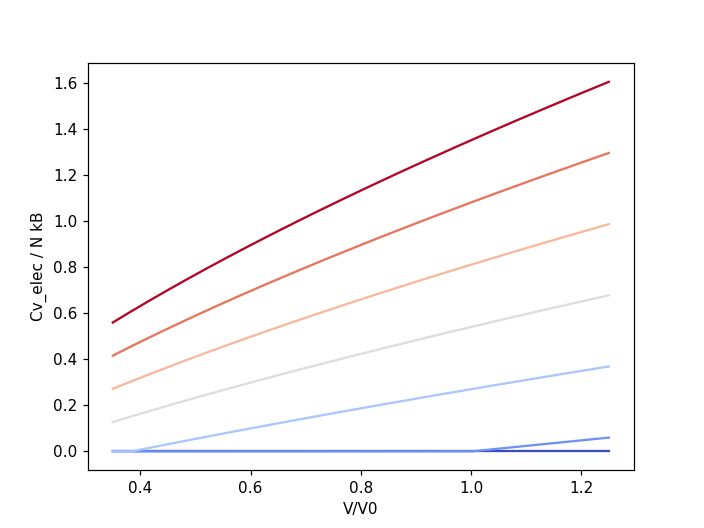

In [6]:
plt.figure()

for T in Tmod:
    plt.plot(Vfrac, eos_mod.heat_capacity(Vmod,T)/kboltz,'-',
             color=cmap((T-2000)/(8000-2000)))
    
    

plt.xlabel('V/V0')
plt.ylabel('Cv_elec / N kB')

In [7]:
# def resid_S_elec(param, V=dat['V'], T=dat['T'], S=dat['S']):
#     Smodel = eval_S_elec(V, T, param)
#     resid_S = Smodel-S
#     return resid_S

def resid_S_elec(param, Vratio=dat['Vratio'], T=dat['T'], S=dat['S'], eos_mod=eos_mod):

    param_names = ['Tel0', 'TelExp', 'CvelFac0', 'CvelFacExp']
    eos_mod.set_param_values(param_names=param_names, param_values=param)
    V0, = eos_mod.get_param_values(param_names=['V0']) 
    V = Vratio*V0
    
    # Smodel = eval_S_elec(Vratio, T, param)
    Smodel = eos_mod.entropy(V, T)/kboltz
    resid_S = Smodel-S
    
    return resid_S

# print(np.array(resid_S_elec(paramf)))
# print(np.array(paramf))

In [8]:

results = optimize.leastsq(resid_S_elec,param0)
paramf = results[0]
print(paramf)
param_names = ['Tel0', 'TelExp', 'CvelFac0', 'CvelFacExp']
eos_mod.set_param_values(param_names=param_names, param_values=paramf)


[  2.46659883e+03  -4.57801641e-01   2.27133196e-04   6.77736044e-01]


In [9]:
eos_mod.entropy(Vmod,T)

array([  1.18692899e-05,   1.19213891e-05,   1.19735159e-05, ...,
         6.64912306e-05,   6.65451072e-05,   6.65989802e-05])

<IPython.core.display.Javascript object>


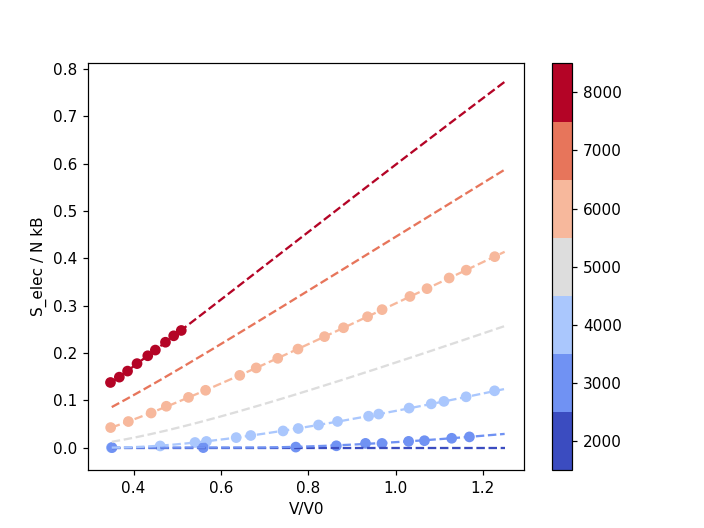

In [10]:

plt.figure()

plt.scatter(dat['Vratio'],dat['S'],c=dat['T'],cmap=cmap)

Tmod = [2000,3000,4000,5000,6000,7000,8000]

for T in Tmod:
    plt.plot(Vfrac, eos_mod.entropy(Vmod,T)/kboltz,'--',
             color=cmap((T-2000)/(8000-2000)))

plt.colorbar()
plt.clim(1500,8500)
plt.xlabel('V/V0')
plt.ylabel('S_elec / N kB')

<IPython.core.display.Javascript object>


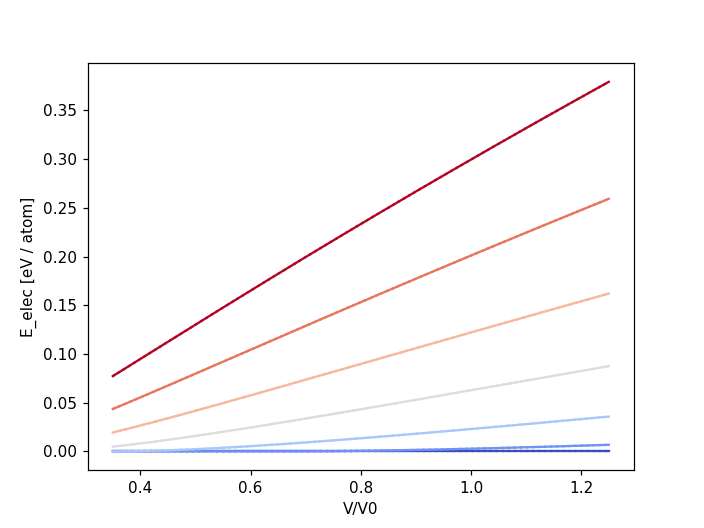

In [11]:
plt.figure()

for T in Tmod:
    plt.plot(Vfrac, eos_mod.energy(Vmod,T),':',
             color=cmap((T-2000)/(8000-2000)))
    plt.plot(Vfrac, eval_E_elec(Vfrac,T,paramf),'-',
             color=cmap((T-2000)/(8000-2000)))
    
    



plt.xlabel('V/V0')
plt.ylabel('E_elec [eV / atom]')

<IPython.core.display.Javascript object>


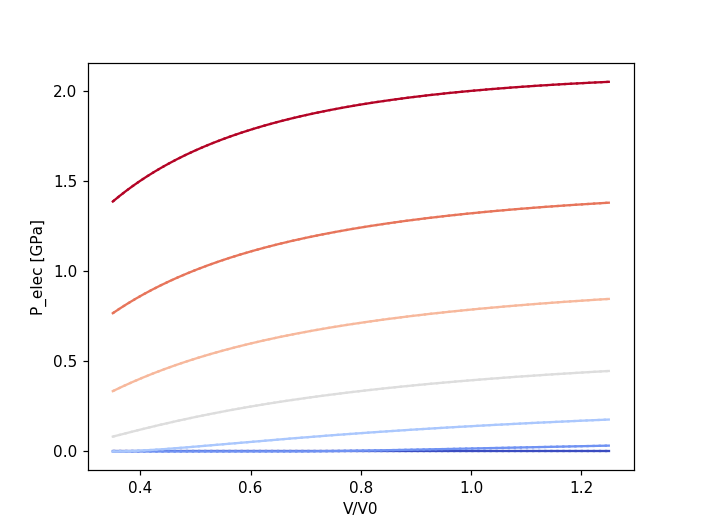

In [12]:
V0, = eos_mod.get_param_values(param_names=['V0'])
plt.figure()

for T in Tmod:
    plt.plot(Vfrac, eval_P_elec(Vfrac,T,paramf, V0=V0),':',
             color=cmap((T-2000)/(8000-2000)))
    plt.plot(Vfrac, eos_mod.press(Vfrac*V0,T),'-',
             color=cmap((T-2000)/(8000-2000)))
    
    

plt.xlabel('V/V0')
plt.ylabel('P_elec [GPa]')